##### Install Libraries

* Please uncomment the code below to install Pytorch before running this notebook first time in the new environment.

In [1]:
# !pip install torch

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import Capstone_Utilities as utility

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random

### Loading ML dataset

In [3]:
datafile_name = 'Capstone_final_dataset_for_ml_50ms.csv'
data = pd.read_csv(datafile_name,index_col=0)
print('dataset for ML:',data.shape)
data.head()

dataset for ML: (718277, 87)


,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,age,height,...,tonic_peaks,tonic_rms,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,label
0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,29.119919,1.025521,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
1,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,29.119755,0.710013,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
2,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,29.125584,0.327802,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
3,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,29.133441,-0.066877,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
4,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,29.122919,-0.490505,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1


#### Convert/map labels from 0 to 3 
* PyTorch supports labels starting from 0. That is [0, n]. We need to remap our labels to start from 0
* Labels in the Dataset are:1 for Baseline, 2 for Stress, 3 for Amusement and 4 for Meditation

In [4]:
print(data.label.unique())

[1 2 3 4]


In [5]:
class2idx = {1:0,2:1,3:2,4:3}

idx2class = {v: k for k, v in class2idx.items()}

data['label'].replace(class2idx, inplace=True)

print(data.label.unique())

data.head()

[0 1 2 3]


,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,age,height,...,tonic_peaks,tonic_rms,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,label
0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,29.119919,1.025521,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,0
1,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,29.119755,0.710013,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,0
2,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,29.125584,0.327802,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,0
3,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,29.133441,-0.066877,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,0
4,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,29.122919,-0.490505,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,0


In [6]:
# Create dataset for Model
X_data = data.iloc[:,0:-1]
y_data = data.iloc[:,-1]

print('X_data.shape:',X_data.shape)
print('Y_data.shape:',y_data.shape)
display(X_data.head())

X_data.shape: (718277, 86)
Y_data.shape: (718277,)


,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,age,height,...,tonic_energy,tonic_peaks,tonic_rms,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms
0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,29.119919,1.025521,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
1,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,29.119755,0.710013,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
2,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,29.125584,0.327802,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
3,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,29.133441,-0.066877,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
4,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,29.122919,-0.490505,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939


##### Split data into train, validate and test sets

In [7]:
X_train,X_val,X_test,y_train,y_val,y_test = utility.split_data(X_data,y_data)

print('Traing Shape:',X_train.shape,y_train.shape)
print('Validation Shape:',X_val.shape,y_val.shape)
print('Testing Shape:',X_test.shape,y_test.shape)

Traing Shape: (574621, 86) (574621,)
Validation Shape: (71828, 86) (71828,)
Testing Shape: (71828, 86) (71828,)


##### Normalize Data

In [8]:
# Scale dataset before applying machine learning
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

##### Visualize class distribution in train, val and test dataset

In [9]:
def get_class_distribution(obj):
    count_dict = {
        "baseline_1": 0,
        "stess_2": 0,
        "amusement_3": 0,
        "meditation_4": 0
    }
    for i in obj:
        if i == 0: 
            count_dict['baseline_1'] += 1
        elif i == 1: 
            count_dict['stess_2'] += 1
        elif i == 2: 
            count_dict['amusement_3'] += 1
        elif i == 3: 
            count_dict['meditation_4'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

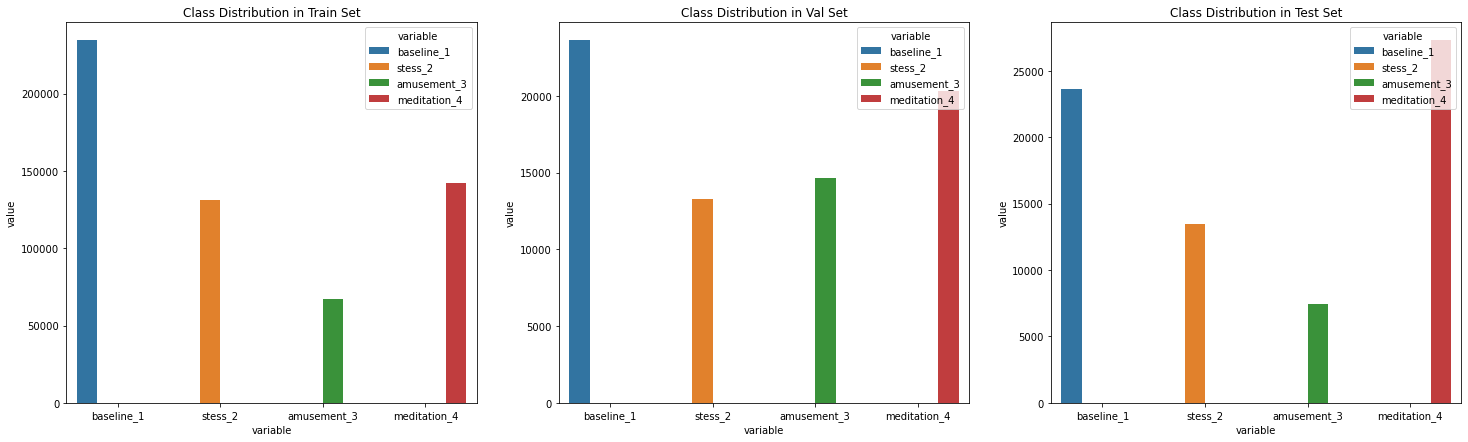

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')
plt.show()

### Neural Network Modeling

#### Sensor Dataset
This dataset will be used by the dataloader to pass the data into model. The X values need to in float while y values need to be in long format.

In [11]:
class SensorDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        x,y = self.X_data[index], self.y_data[index]
        return x,y
    
    def __len__ (self):
        return len(self.X_data)

train_dataset = SensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = SensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = SensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

##### Weighted Sampling

As it is observed in the graph above that there is a class imbalance, and even though stratified split was used but still it does not ensure that each mini-batch of the model gets representation from all the classes.

We need to over-sample the classes with less number of values using WeightedRandomSampler.

In [12]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
print('Target list length:',len(target_list))

Target list length: 574621


In [13]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([4.2679e-06, 7.6389e-06, 1.4880e-05, 7.0325e-06])


In [14]:
# assign weight for each sample
class_weights_all = class_weights[target_list]

In [15]:
# Initialize weighted Random Sampler
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

##### Neural Network Architecture

* A simple 3-layer feed-forward network with dropout and batch-norm.

In [16]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)  
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


##### Calculate Accuracy
This function takes y_pred and y_test as input arguments. We then apply log_softmax to y_pred and extract the class which has a higher probability.After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [28]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

##### Model Hyper Parameters

Below code is commented post Hyper parameter tuning, please uncomment to run and determine the best hyper parameter values: Batch Size and Learning Rate.

In [27]:
# EPOCHS = 5
# BATCH_SIZE = [8,32,64,128]
# LEARNING_RATE = [0.0001,0.001,0.01]
# NUM_FEATURES = len(X_data.columns)
# NUM_CLASSES = 4 # four effective states label

#### Initialize Model, Optimizer and Loss Function

* Using the nn.CrossEntropyLoss because this is a multiclass classification problem. 
* No need to apply a log_softmax layer after our final layer because nn.CrossEntropyLoss does that for us. However, we need to apply log_softmax for our validation and testing.

In [30]:
# def best_nn_parameters_training_data(train_dataset,val_dataset):
#     for learning_rate in LEARNING_RATE:
#         for batch_size in BATCH_SIZE:
            
#             # initialize model
#             model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
#             model.to(device)
#             criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
#             optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            
#             # get train, val and test loader
#             train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,sampler=weighted_sampler)
#             val_loader = DataLoader(dataset=val_dataset, batch_size=1)
#             test_loader = DataLoader(dataset=test_dataset, batch_size=1)
            
#             print("++++++++++ Begin training.++++++++++++++++++")
#             print('Learning Rate: {} Batch Size: {}'.format(learning_rate,batch_size))
                    
#             for e in tqdm(range(1, EPOCHS+1)):
    
#                 # TRAINING
#                 train_epoch_loss = 0
#                 train_epoch_acc = 0
#                 model.train()
#                 for X_train_batch, y_train_batch in train_loader:
                    
#                     X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
#                     optimizer.zero_grad()
        
#                     y_train_pred = model(X_train_batch)
        
#                     train_loss = criterion(y_train_pred, y_train_batch)
#                     train_acc = multi_acc(y_train_pred, y_train_batch)
        
#                     train_loss.backward()
#                     optimizer.step()
        
#                     train_epoch_loss += train_loss.item()
#                     train_epoch_acc += train_acc.item()
        
        
#                 # VALIDATION    
#                 with torch.no_grad():
        
#                     val_epoch_loss = 0
#                     val_epoch_acc = 0
        
#                     model.eval()
#                     for X_val_batch, y_val_batch in val_loader:
#                         X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
#                         y_val_pred = model(X_val_batch)
#                         val_loss = criterion(y_val_pred, y_val_batch)
#                         val_acc = multi_acc(y_val_pred, y_val_batch)
#                         val_epoch_loss += val_loss.item()
#                         val_epoch_acc += val_acc.item()
            
#                 print(f'Epoch {e+0:03}:| Train Loss: {train_epoch_loss/len(train_loader):.5f}| Val Loss: {val_epoch_loss/len(val_loader):.5f}| Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

In [31]:
# best_nn_parameters_training_data(train_dataset,val_dataset)

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.0001 Batch Size: 8


Epoch 001:| Train Loss: 0.25852| Val Loss: 12.01040| Train Acc: 90.168| Val Acc: 25.681
Epoch 002:| Train Loss: 0.09337| Val Loss: 15.27359| Train Acc: 97.046| Val Acc: 31.354
Epoch 003:| Train Loss: 0.06904| Val Loss: 19.07521| Train Acc: 97.911| Val Acc: 34.356
Epoch 004:| Train Loss: 0.05611| Val Loss: 20.43775| Train Acc: 98.315| Val Acc: 29.108
Epoch 005:| Train Loss: 0.04849| Val Loss: 19.07369| Train Acc: 98.558| Val Acc: 30.961

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.0001 Batch Size: 32


Epoch 001:| Train Loss: 0.11949| Val Loss: 9.33514| Train Acc: 95.547| Val Acc: 28.223
Epoch 002:| Train Loss: 0.02420| Val Loss: 11.53434| Train Acc: 99.232| Val Acc: 21.180
Epoch 003:| Train Loss: 0.01581| Val Loss: 15.36699| Train Acc: 99.483| Val Acc: 26.815
Epoch 004:| Train Loss: 0.01253| Val Loss: 17.31764| Train Acc: 99.599| Val Acc: 27.404
Epoch 005:| Train Loss: 0.01061| Val Loss: 17.37468| Train Acc: 99.653| Val Acc: 27.221

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.0001 Batch Size: 64


Epoch 001:| Train Loss: 0.11619| Val Loss: 10.86227| Train Acc: 96.043| Val Acc: 25.672
Epoch 002:| Train Loss: 0.01564| Val Loss: 11.30888| Train Acc: 99.419| Val Acc: 28.248
Epoch 003:| Train Loss: 0.01054| Val Loss: 12.88456| Train Acc: 99.582| Val Acc: 31.318
Epoch 004:| Train Loss: 0.00783| Val Loss: 16.90210| Train Acc: 99.688| Val Acc: 36.127
Epoch 005:| Train Loss: 0.00684| Val Loss: 18.08061| Train Acc: 99.719| Val Acc: 24.820

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.0001 Batch Size: 128


Epoch 001:| Train Loss: 0.12563| Val Loss: 7.79906| Train Acc: 95.307| Val Acc: 27.265
Epoch 002:| Train Loss: 0.01286| Val Loss: 10.53835| Train Acc: 99.554| Val Acc: 27.269
Epoch 003:| Train Loss: 0.00824| Val Loss: 13.17637| Train Acc: 99.678| Val Acc: 28.197
Epoch 004:| Train Loss: 0.00693| Val Loss: 14.46230| Train Acc: 99.725| Val Acc: 27.489
Epoch 005:| Train Loss: 0.00600| Val Loss: 16.58064| Train Acc: 99.766| Val Acc: 27.390

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.001 Batch Size: 8


Epoch 001:| Train Loss: 0.24796| Val Loss: 19.83212| Train Acc: 91.006| Val Acc: 18.490
Epoch 002:| Train Loss: 0.11808| Val Loss: 16.70459| Train Acc: 96.317| Val Acc: 24.960
Epoch 003:| Train Loss: 0.08794| Val Loss: 19.49171| Train Acc: 97.347| Val Acc: 21.542
Epoch 004:| Train Loss: 0.07363| Val Loss: 12.23373| Train Acc: 97.850| Val Acc: 26.350
Epoch 005:| Train Loss: 0.06491| Val Loss: 15.21932| Train Acc: 98.119| Val Acc: 34.379

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.001 Batch Size: 32


Epoch 001:| Train Loss: 0.08550| Val Loss: 16.39973| Train Acc: 96.797| Val Acc: 18.490
Epoch 002:| Train Loss: 0.02833| Val Loss: 22.71163| Train Acc: 99.108| Val Acc: 27.297
Epoch 003:| Train Loss: 0.01990| Val Loss: 21.54022| Train Acc: 99.344| Val Acc: 28.486
Epoch 004:| Train Loss: 0.01543| Val Loss: 28.61303| Train Acc: 99.494| Val Acc: 25.702
Epoch 005:| Train Loss: 0.01344| Val Loss: 22.52461| Train Acc: 99.559| Val Acc: 28.173

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.001 Batch Size: 64


Epoch 001:| Train Loss: 0.06570| Val Loss: 12.77741| Train Acc: 97.394| Val Acc: 24.912
Epoch 002:| Train Loss: 0.01948| Val Loss: 12.08444| Train Acc: 99.233| Val Acc: 28.213
Epoch 003:| Train Loss: 0.01353| Val Loss: 21.51860| Train Acc: 99.474| Val Acc: 24.648
Epoch 004:| Train Loss: 0.01028| Val Loss: 26.42848| Train Acc: 99.586| Val Acc: 21.932
Epoch 005:| Train Loss: 0.00860| Val Loss: 28.01353| Train Acc: 99.645| Val Acc: 25.823

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.001 Batch Size: 128


Epoch 001:| Train Loss: 0.05896| Val Loss: 12.41507| Train Acc: 97.583| Val Acc: 27.386
Epoch 002:| Train Loss: 0.01505| Val Loss: 15.98821| Train Acc: 99.419| Val Acc: 25.714
Epoch 003:| Train Loss: 0.01036| Val Loss: 17.25846| Train Acc: 99.577| Val Acc: 27.893
Epoch 004:| Train Loss: 0.00866| Val Loss: 19.39528| Train Acc: 99.637| Val Acc: 25.645
Epoch 005:| Train Loss: 0.00687| Val Loss: 29.28958| Train Acc: 99.712| Val Acc: 25.741

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.01 Batch Size: 8


Epoch 001:| Train Loss: 0.35345| Val Loss: 9.85243| Train Acc: 86.341| Val Acc: 30.009
Epoch 002:| Train Loss: 0.18163| Val Loss: 11.05412| Train Acc: 94.059| Val Acc: 25.931
Epoch 003:| Train Loss: 0.14139| Val Loss: 16.92841| Train Acc: 95.510| Val Acc: 27.848
Epoch 004:| Train Loss: 0.12022| Val Loss: 26.19610| Train Acc: 96.290| Val Acc: 20.587
Epoch 005:| Train Loss: 0.10606| Val Loss: 25.60307| Train Acc: 96.784| Val Acc: 18.589

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.01 Batch Size: 32


Epoch 001:| Train Loss: 0.11987| Val Loss: 18.66579| Train Acc: 95.497| Val Acc: 18.490
Epoch 002:| Train Loss: 0.04165| Val Loss: 21.89272| Train Acc: 98.686| Val Acc: 26.909
Epoch 003:| Train Loss: 0.03046| Val Loss: 31.17950| Train Acc: 99.045| Val Acc: 25.820
Epoch 004:| Train Loss: 0.02525| Val Loss: 32.73470| Train Acc: 99.225| Val Acc: 25.887
Epoch 005:| Train Loss: 0.02137| Val Loss: 33.34897| Train Acc: 99.359| Val Acc: 27.684

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.01 Batch Size: 64


Epoch 001:| Train Loss: 0.09062| Val Loss: 12.53478| Train Acc: 96.330| Val Acc: 25.537
Epoch 002:| Train Loss: 0.02798| Val Loss: 18.84486| Train Acc: 98.944| Val Acc: 28.198
Epoch 003:| Train Loss: 0.01901| Val Loss: 26.70067| Train Acc: 99.293| Val Acc: 27.449
Epoch 004:| Train Loss: 0.01650| Val Loss: 33.67975| Train Acc: 99.375| Val Acc: 28.213
Epoch 005:| Train Loss: 0.01363| Val Loss: 44.21126| Train Acc: 99.467| Val Acc: 25.734

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.01 Batch Size: 128


Epoch 001:| Train Loss: 0.07328| Val Loss: 11.09840| Train Acc: 96.944| Val Acc: 24.701
Epoch 002:| Train Loss: 0.02323| Val Loss: 17.94450| Train Acc: 99.173| Val Acc: 24.393
Epoch 003:| Train Loss: 0.01487| Val Loss: 23.73829| Train Acc: 99.423| Val Acc: 25.741
Epoch 004:| Train Loss: 0.01258| Val Loss: 40.59099| Train Acc: 99.513| Val Acc: 25.853
Epoch 005:| Train Loss: 0.01045| Val Loss: 42.86342| Train Acc: 99.580| Val Acc: 25.759



#### Model Best Parameters

From Hyperparameter tuning, below found as the best hyper parameters for model to train and test

Learning Rate: 0.0001 Batch Size: 64

#### Model Final Training using best hyper parameters value

In [32]:
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_FEATURES = len(X_data.columns)
NUM_CLASSES = 4 # four effective states label

train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,sampler=weighted_sampler)

val_loader = DataLoader(dataset=val_dataset, batch_size=1)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [33]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=86, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [34]:
# store accuracy and loss
accuracy_stats = { 'train': [],"val": [] }
loss_stats = {'train': [],"val": [] }

In [35]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 0.11383 | Val Loss: 7.42336 | Train Acc: 95.857 | Val Acc: 29.644
Epoch 002: | Train Loss: 0.01649 | Val Loss: 9.21983 | Train Acc: 99.392 | Val Acc: 28.444
Epoch 003: | Train Loss: 0.01056 | Val Loss: 14.15201 | Train Acc: 99.582 | Val Acc: 27.709
Epoch 004: | Train Loss: 0.00821 | Val Loss: 14.48345 | Train Acc: 99.669 | Val Acc: 29.040
Epoch 005: | Train Loss: 0.00729 | Val Loss: 12.26252 | Train Acc: 99.707 | Val Acc: 31.346
Epoch 006: | Train Loss: 0.00629 | Val Loss: 19.73886 | Train Acc: 99.741 | Val Acc: 28.027
Epoch 007: | Train Loss: 0.00540 | Val Loss: 18.92825 | Train Acc: 99.768 | Val Acc: 25.656
Epoch 008: | Train Loss: 0.00520 | Val Loss: 26.10651 | Train Acc: 99.783 | Val Acc: 28.148
Epoch 009: | Train Loss: 0.00471 | Val Loss: 21.26749 | Train Acc: 99.802 | Val Acc: 28.142
Epoch 010: | Train Loss: 0.00450 | Val Loss: 20.67193 | Train Acc: 99.807 | Val Acc: 27.509



##### Visualize Loss and Accuracy

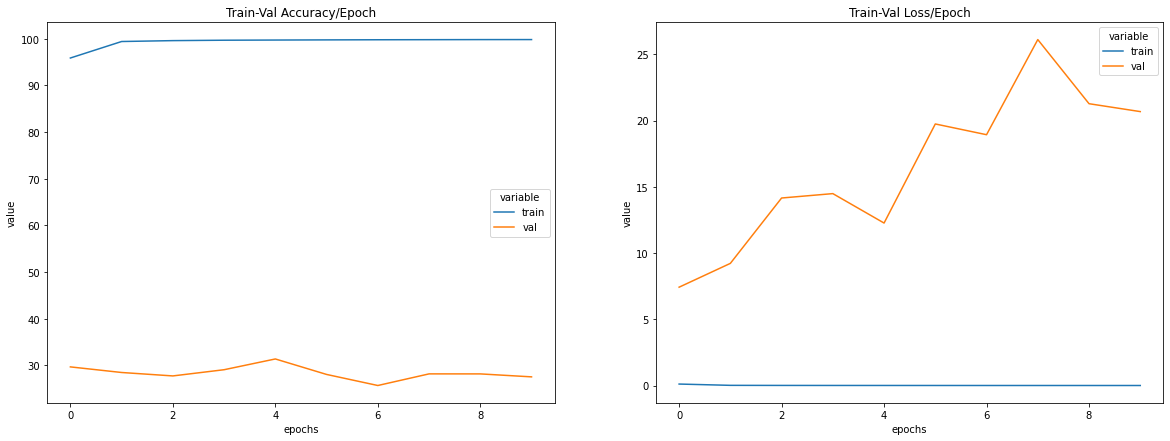

In [37]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')
plt.show()

##### Test the Model

In [39]:
y_pred_list = []
y_test_target_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_test_target in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_target_list.append(y_test_target.to(device))
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

##### Confusion Matrix

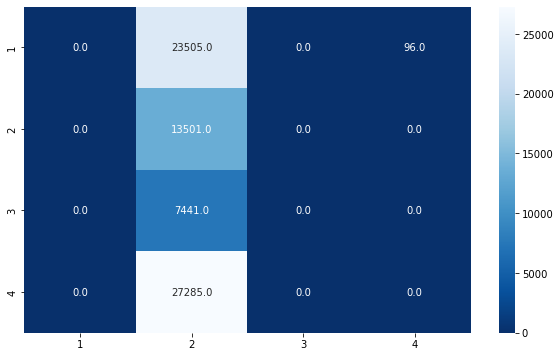

In [43]:
plt.figure(figsize=(10,6))
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True,fmt=".1f",cmap="Blues_r")
plt.show()

##### Classification Report

In [44]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     23601
           1       0.19      1.00      0.32     13501
           2       0.00      0.00      0.00      7441
           3       0.00      0.00      0.00     27285

    accuracy                           0.19     71828
   macro avg       0.05      0.25      0.08     71828
weighted avg       0.04      0.19      0.06     71828

